In [1]:
import pandas as pd
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import glob
import os
# import matplotlib as mpl

In [2]:
def Unitvector(x_gauss, y_gauss):
    from sklearn import preprocessing
    
    # get the slope of the tangent
    trajectory = np.asarray([x_gauss, y_gauss])
    m = np.gradient(trajectory, axis = 1)
    m_atx = m[1]/m[0]
    
    # get the tangent vector at x = x0 + 1
    tangent_x = x_gauss+1
    tangent_y = m_atx + y_gauss
    
    # get the unit tangent vector
    u_x = []
    u_y = []

    for x,y,x0,y0 in zip(tangent_x, tangent_y, x_gauss, y_gauss):
        if np.any(np.isnan([x, y])) or np.any(np.isinf([x, y])):
            unit_x = np.nan
            unit_y = np.nan
        else:
            vector = np.asarray([x-x0, y-y0]).reshape(1,-1)
            [unit_x, unit_y] = preprocessing.normalize(vector, norm = 'l2')[0]
        u_x.append(unit_x)
        u_y.append(unit_y)
    u_x = np.asarray(u_x)
    u_y = np.asarray(u_y)
    return(u_x, u_y)


def getAngle(loc, tangent):
    cross = np.cross(tangent, loc)
    dot = np.dot(tangent, loc)
    angle = np.arctan2(cross, dot)*180/np.pi
    return(angle)

def angleCorloredTrajectory(x_gauss, y_gauss, angle):
    
    fig = plt.subplots(figsize = (5,5))
    plt.scatter(x_gauss, y_gauss, s=7 , c = angle, cmap = plt.cm.jet)
    c1 = plt.Circle((0, 0), circ_r, facecolor='grey', alpha=0.3, edgecolor='none')
    ax = plt.gca()
    ax.add_artist(c1)
    ax.set_aspect('equal', adjustable = 'datalim')
    cbar = plt.colorbar()
    return(fig)

def angleColoredSweepCurves(r_gauss, circ_r, angle):
    fig = plt.subplots(figsize = (5,5))
    t0 = np.arange(len(r_gauss))*1/100
    plt.scatter(t0, r_gauss/circ_r, s = 10,
                c = angle, cmap = plt.cm.jet)
    cbar = plt.colorbar()
    return(fig)

def wrapAngle(angle):
    angle = np.absolute(angle)
    for i,a in enumerate(angle):
        if a > 90:
            a = 180 - a
            angle[i] = a
    return(angle)    

In [3]:
data_path = './dataFolders/FinalTracking_xypts/filteredUsingThreshold/v1/'
out_path = './dataFolders/FinalTracking_xypts/AngleAndRadiusIncluded/v1'

try:
    os.mkdir('./dataFolders/FinalTracking_xypts/AngleAndRadiusIncluded//v1/cutoff20')
    os.mkdir('./dataFolders/FinalTracking_xypts/AngleAndRadiusIncluded//v1/cutoff24')
except:
    print('oops')

oops


In [4]:
circ_parameters = pd.read_csv('./dataFolders/circle_parameters.csv')

In [5]:
# parameters used to filter data

interpol_order = 3 # order for polynomial interpolation

win_gauss = signal.gaussian(10,3) # gaussian kernal for smoothening interpolated data

# parameters for the savitzky-golay filter
savgol_win = 15
savgol_polyorder = 3

In [6]:
for cutoff in ['cutoff20', 'cutoff24']:
    datalist = glob.glob(data_path + '/' + cutoff + '/**.csv')
    for path in datalist:
        
        file = pd.read_csv(path)
        x = file.tracked_x
        y = file.tracked_y

        name = [n for n in circ_parameters.name if n in path][0]

        circ_x = circ_parameters.loc[circ_parameters.name == name, 'circ_x'].values
        circ_y = circ_parameters.loc[circ_parameters.name == name, 'circ_y'].values
        circ_radii = circ_parameters.loc[circ_parameters.name == name, 'circ_radii'].values

        cent_x = x - circ_x
        cent_y = y - circ_y

        x_interpl = cent_x.interpolate(method='polynomial', order=interpol_order)
        y_interpl = cent_y.interpolate(method='polynomial', order=interpol_order)

        r = np.linalg.norm([x_interpl, y_interpl], axis = 0)
        r = r/circ_radii
        
        #smoothen data
        # gaussian method
        x_gauss = signal.convolve(x_interpl, win_gauss, 
                                      mode='same', method = 'direct') / win_gauss.sum()
        y_gauss = signal.convolve(y_interpl, win_gauss, 
                                      mode = 'same', method = 'direct') / win_gauss.sum()
        r_gauss = np.linalg.norm([x_gauss, y_gauss], axis = 0)
        r_gauss_norm = r_gauss/circ_radii
        
        # savitzky-golay method
        x_savgol = signal.savgol_filter(x_interpl, savgol_win, savgol_polyorder)
        y_savgol = signal.savgol_filter(y_interpl, savgol_win, savgol_polyorder)
        r_savgol = np.linalg.norm([x_savgol, y_savgol], axis = 0)
        r_savgol_norm = r_savgol/circ_radii

        # save all usable variables as series

        df1 = pd.Series(data = x_gauss, name = 'x_gauss')
        df2 = pd.Series(data = y_gauss, name = 'y_gauss')
        df3 = pd.Series(data = r, name = 'radial distance')
        df4 = pd.Series(data = r_gauss_norm, name = 'radial distance gaussian')
        df5 = pd.Series(data = x_savgol, name = 'x_savgol')
        df6 = pd.Series(data = y_savgol, name = 'y_savgol')
        df7 = pd.Series(data = r_savgol_norm, name = 'radial distance savgol')


        #calculate the unit tangent vectors - gauss vector
        u_x, u_y = Unitvector(x_gauss, y_gauss)

        angle_gauss = []
        for x0, y0, x, y in zip(x_gauss, y_gauss, u_x, u_y):
            loc = [x0, y0]
            tangent = [x, y]
            a = getAngle(loc, tangent)
            angle_gauss.append(a)
            
        angle_gauss = wrapAngle(angle_gauss)

        df8 = pd.Series(data = angle_gauss, name = 'angle_gauss')
        
        #calculate the unit tangent vectors - savitzky-golay vector
        u_x, u_y = Unitvector(x_savgol, y_savgol)

        angle_savgol = []
        for x0, y0, x, y in zip(x_savgol, y_savgol, u_x, u_y):
            loc = [x0, y0]
            tangent = [x, y]
            a = getAngle(loc, tangent)
            angle_savgol.append(a)
            
        angle_savgol = wrapAngle(angle_savgol)

        df9 = pd.Series(data = angle_savgol, name = 'angle_savgol')
       
        new_file = pd.concat([file, df3, df1, df2, df4, df8, df5, df6, df7, df9], axis = 1)

        _,tail = os.path.split(path)
        new_path = os.path.join(out_path, cutoff, tail)
#         new_path = out_path + '/' + cutoff + '/' + tail
        new_file.to_csv(new_path)

C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_savitzky_golay.py:187: RankWarning: Polyfit may be poorly conditioned
  xx_edge, polyorder)
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_savitzky_golay.py:187: RankWarning: Polyfit may be poorly conditioned
  xx_edge, polyorder)
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_savitzky_golay.py:187: RankWarning: Polyfit may be poorly conditioned
  xx_edge, polyorder)
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_savitzky_golay.py:187: RankWarning: Polyfit may be poorly conditioned
  xx_edge, polyorder)
C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\signal\_savitzky_golay.py:187: RankWarning: Polyfit may be poorly conditi

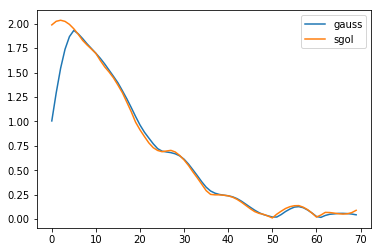

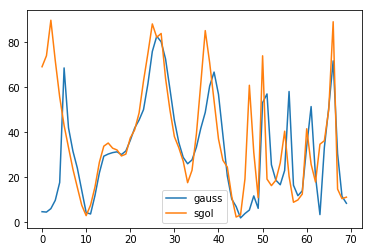

In [115]:
plt.plot(r_gauss_norm, label = 'gauss')
plt.plot(r_savgol_norm, label = 'sgol')
plt.legend()
plt.show()

plt.plot(angle_gauss[0:100], label = 'gauss')
plt.plot(angle_savgol[0:100], label = 'sgol')
plt.legend()

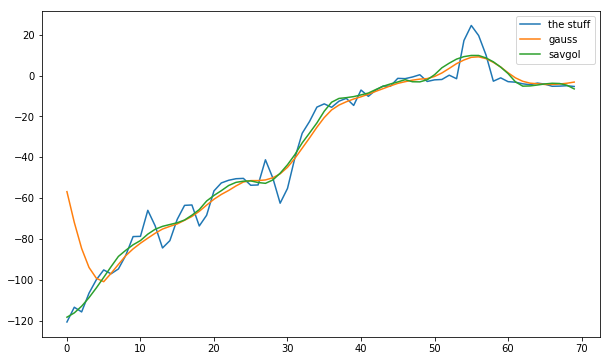

In [117]:
plt.subplots(figsize = (10,6))
plt.plot(x_interpl.values[:], label = 'the stuff')
plt.plot(x_gauss[:], label = 'gauss')
plt.plot(x_savgol[:], label = 'savgol')
plt.legend()